# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [7]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [8]:
# Read the Mapbox API key
load_dotenv("joanne.env")
map_box_api = os.getenv("MAPBOX")
px.set_mapbox_access_token(map_box_api)
type(map_box_api)

str

# Import Data

In [18]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [29]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    housing_units = sf_data['housing_units'].groupby(['year']).mean()
    
    figure_housing_units = plt.figure()
    plot_figure_units = housing_units.plot.bar()
    plot_figure_units.set_xlabel('Year')
    plot_figure_units.set_ylabel('Housing Units')
    plot_figure_units.set_title('Housing Units in San Francisco from 2010 to 2016', fontweight='bold')

    plt.close(figure_housing_units)

    return pn.pane.Matplotlib(figure_housing_units, tight=True)


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    ave_costs =sfo_data[["sale_price_sqr_foot","gross_rent"]].groupby(['year']).mean()
    
    figure = plt.figure()
    line_chart = ave_costs['gross_rent'].plot()
    line_chart.set_xlabel('Year')
    line_chart.set_ylabel('Gross Rent')
    line_chart.set_title('', fontweight='bold')
    plt.close(figure)

    return pn.pane.Matplotlib(figure, tight=True)

def average_sales_price():
    """Average Sales Price Per Year."""
    
    ave_costs =sfo_data[["sale_price_sqr_foot","gross_rent"]].groupby(['year']).mean()
    
    figure = plt.figure()
    line_chart = ave_costs['sale_price_sqr_foot'].plot()
    line_chart.set_xlabel('Year')
    line_chart.set_ylabel('Price per sq foot')
    line_chart.set_title('', fontweight='bold')
    plt.close(figure)

    return pn.pane.Matplotlib(figure, tight=True)

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    sfo_data_df = sfo_data.groupby([sfo_data.index,"neighborhood"]).mean()
    sfo_data_df.reset_index(inplace = True)

    plot = sfo_data_df.hvplot.line(
    x="year", 
    y="sale_price_sqr_foot", 
    xlabel='Year',
    ylabel='Sale Price sqr Foot',
    title="Average price per sq ft per year",
    groupby='neighborhood'
    )
    
    return plot

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""

    top10_expensive_neighborhoods = sfo_data.groupby(["neighborhood"]).mean()
    top10_expensive_neighborhoods = top10_expensive_neighborhoods.sort_values(['sale_price_sqr_foot'], ascending =False)
    top10_expensive_neighborhoods = top10_expensive_neighborhoods.reset_index().head(10)

    top10_plot = top10_expensive_neighborhoods.hvplot.bar(
    x = "neighborhood",
    y = "sale_price_sqr_foot",
    xlabel='Neighborhood',
    ylabel='Average Sale Price per sq foot',
    title = "Top 10 Expensive Neighborhoods in SFO",
    height=450,
    rot = 90
    )
    
    return top10_plot

def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    
    sfo_data_df = sfo_data.groupby([sfo_data.index,"neighborhood"]).mean()
    sfo_data_df.reset_index(inplace = True)

    most_expensive_plot = sfo_data_df.hvplot.bar(
    x = "year",
    y = ["gross_rent","sale_price_sqr_foot"],
    xlabel='Year',
    ylabel='USD',
    title = "Top 10 Expensive Neighborhoods in SFO",
    groupby="neighborhood",
    height=450,
    rot = 90
)
    return most_expensive_plot
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""

    # YOUR CODE HERE!


def neighborhood_map():
    """Neighborhood Map."""

    df_neighborhood = sfo_data.groupby(["neighborhood"]).mean()
    df_neighborhood = df_neighborhood.sort_values(['sale_price_sqr_foot'], ascending =False)
    df_neighborhood = df_neighborhood.reset_index()
    df_neighborhood.rename(columns={'neighborhood':'Neighborhood'}, inplace=True) 
    
    avg_value_location = pd.merge(
    df_neighborhood_locations,df_neighborhood, on='Neighborhood',how='inner')
    
    load_dotenv("joanne.env")
    map_box_api = os.getenv("MAPBOX")
    px.set_mapbox_access_token(map_box_api)
    
    map_plot = px.scatter_mapbox(
    avg_value_location,
    lat="Lat",
    lon="Lon",
    size="sale_price_sqr_foot",
    color="gross_rent",
    size_max=15,
    zoom=11,
    hover_name='Neighborhood',
    title="Average Sale Price per Square Foot and Gross Rent in San Francisco"
    )
    
    plotly_panel = pn.pane.Plotly(map_plot)
    plotly_panel._updates = True
    
    return plotly_panel
    
def sunburst():
    """Sunburst Plot."""
    
    # YOUR CODE HERE!


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [44]:
# Create a Title for the Dashboard
my_title = pn.pane.Markdown(
"""
# Real Estate Analysis of San Francisco from 2010-2016
""",
    width=700,
)

welcome_message = pn.pane.Markdown(
"""
Modify welcome message later 
"""
)

# Create a tab layout for the dashboard
tabs = pn.Tabs(
    ("Welcome",pn.Column(welcome_message,neighborhood_map())),
    ("Yearly Market Analysis",pn.Row(housing_units_per_year(), average_gross_rent(),average_sales_price())),
    ("Neighborhood Analysis",pn.Column(average_price_by_neighborhood(), 
                                       top_most_expensive_neighborhoods(),
                                       most_expensive_neighborhoods_rent_sales()))
)


# Create the dashboard
dashboard = pn.Column(pn.Row(my_title), tabs, width = 900)

## Serve the Panel Dashboard

Column(width=900)
    [0] Row
        [0] Markdown(str, width=700)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Row
            [0] Matplotlib(Figure, tight=True)
            [1] Matplotlib(Figure, tight=True)
            [2] Matplotlib(Figure, tight=True)
        [2] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] HoloViews(Bars)
            [2] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
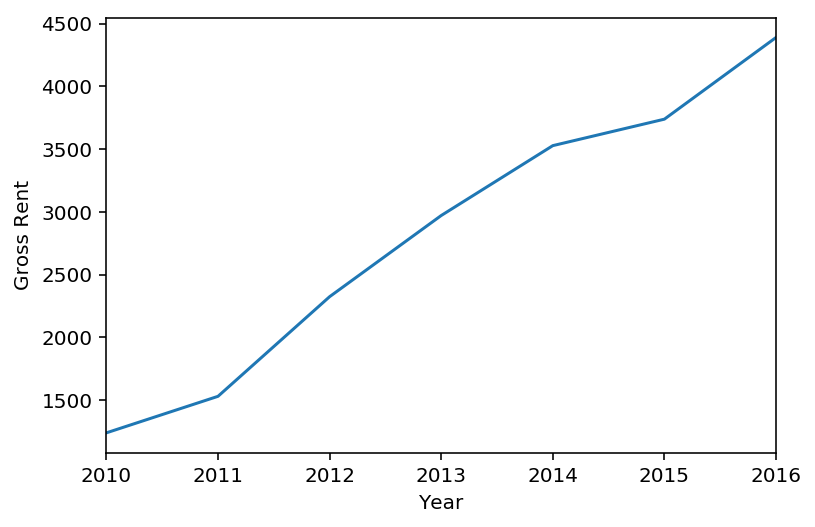
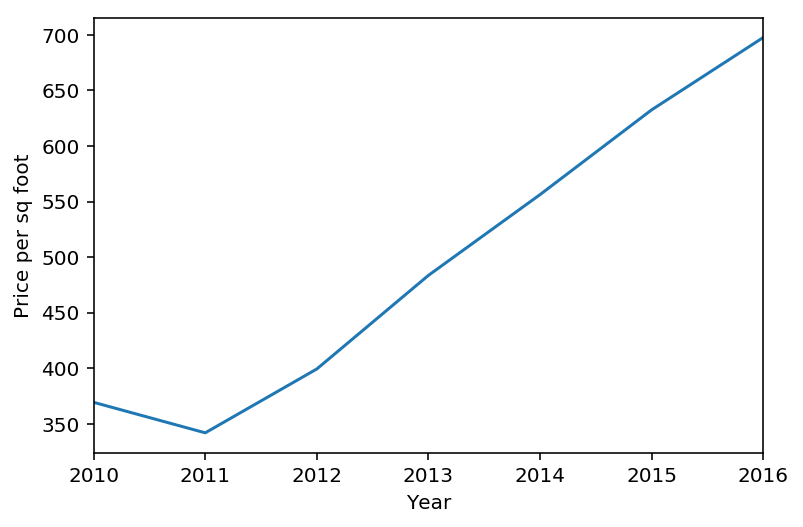
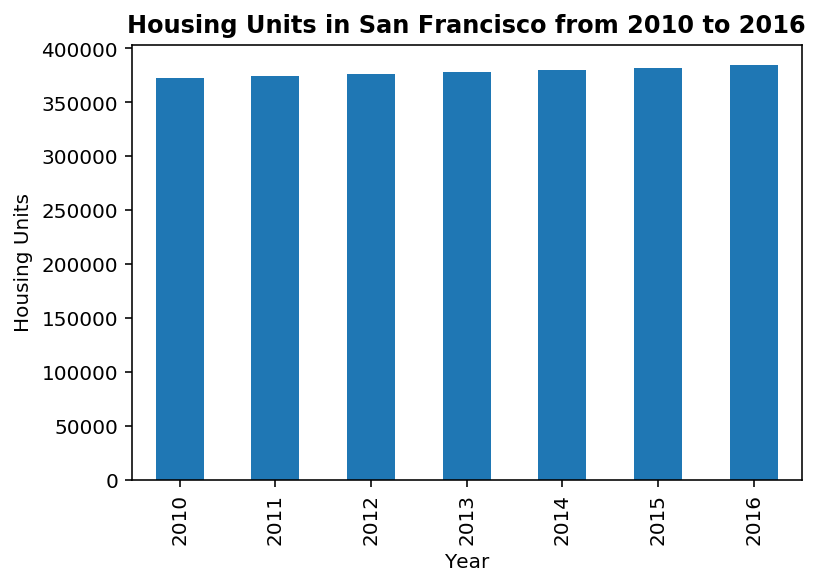

In [45]:
# Serve the# dashboard
dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [12]:
# housing_units_per_year()

In [ ]:
# average_gross_rent()

In [ ]:
# average_sales_price()

In [ ]:
# average_price_by_neighborhood()

In [ ]:
# top_most_expensive_neighborhoods()

In [ ]:
# most_expensive_neighborhoods_rent_sales()

In [ ]:
# neighborhood_map().show()

In [ ]:
# parallel_categories()

In [ ]:
# parallel_coordinates()

In [ ]:
# sunburst()